In [1]:
import os
import getpass
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
import json

In [2]:
os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key:')

In [3]:
# Load jsonld file
data = json.load(open("data/dunbar/bacnet.jsonld"))

In [72]:
# Create the documents to load into the vector store
documents = []

# Loop through the jsonld file and create a document for each
for i in range(0, len(data)):
    # Check if its a bacnet device or point
    type = data[i]["@type"][0]
    if type == "http://data.ashrae.org/bacnet/2016#bacnet_Point":
        device_name = data[i]['http://data.ashrae.org/bacnet/2016#device_name'][0]['@value']
        point_name = data[i]['http://data.ashrae.org/bacnet/2016#object_name'][0]['@value']
        present_value = data[i]['http://data.ashrae.org/bacnet/2016#present_value'][0]['@value']
        unit = data[i]['http://data.ashrae.org/bacnet/2016#object_units'][0]['@value']

        # Create the document
        content = point_name + " " + present_value + " " + unit
        documents.append(Document(page_content=content, metadata={"type": "bacnet_point", }))
    elif type == "http://data.ashrae.org/bacnet/2016#bacnet_Device":
        device_name = data[i]['http://data.ashrae.org/bacnet/2016#device_name'][0]['@value']

        # Create the document
        content = device_name
        # documents.append(Document(page_content=content, metadata={"type": "bacnet_device"}))

In [73]:
# Load the documents into the vector store
db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [74]:
vectorstore_data = db.get(include=["embeddings", "metadatas"])
embs = vectorstore_data["embeddings"]

In [75]:
# Computer required parameters of DBSCAN clustering
# Use KNN to find the optimal epsilon
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Find the optimal epsilon
nbrs = NearestNeighbors(n_neighbors=5).fit(embs)

distances, indices = nbrs.kneighbors(embs)

distances = np.sort(distances, axis=0)

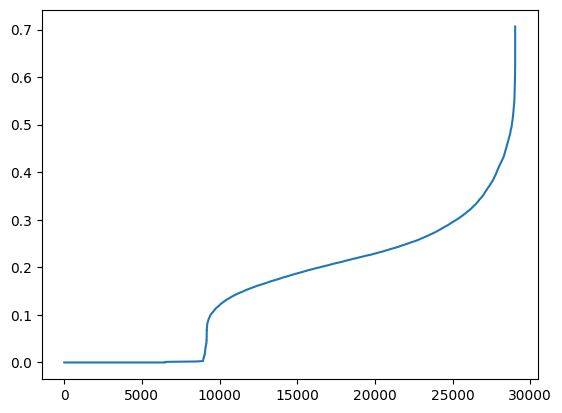

In [76]:
# Now, get the sorted kth column (distances with kth neighbors) and plot the kNN distance plot
import matplotlib.pyplot as plt

plt.plot(distances[:, 4])
plt.show()

In [77]:
# Use knee locator to find the optimal epsilon
from kneed import KneeLocator

kneedle = KneeLocator(
    range(1, distances.shape[0] + 1), distances[:, 1], curve="convex", direction="increasing"
)

kneedle.knee_y

0.4308817788944587

In [78]:
# Compute the DBSCAN clustering
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.43, min_samples=5).fit(embs)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

# Print the results
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 132
Estimated number of noise points: 445


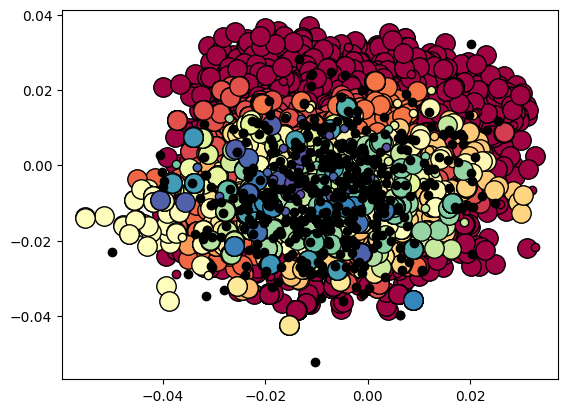

In [79]:
# Plot the results
import matplotlib.pyplot as plt

unique_labels = set(labels)
embs = np.array(embs)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = embs[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = embs[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6) 

In [82]:
# Create a dict of clusters and their bacnet devices
clusters = {}
for i in range(min(len(labels), len(documents))):
    if labels[i] in clusters:
        clusters[labels[i]].append(documents[i].page_content)
    else:
        clusters[labels[i]] = [documents[i].page_content]

# Print the clusters
print(clusters[51])

['4A18FlowMax', '4A12NightHeatSp', 'SuctionTemp2', '7A42Co2SP', 'Unoccupied_HeatShift', '3A24VelPressure', '4A15FlowMin', 'AHU01-MRN-WARM-MODE', 'EffectSpaceTemp', '4A13CoolSp', 'General 3', 'AHU01-FRZ-ALRM', 'cpLocSpEnable', 'SuctionTemp1']
